<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

## Task 1: Project Overview and Import Libraries

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


## Task 2: Load and Preprocess the Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

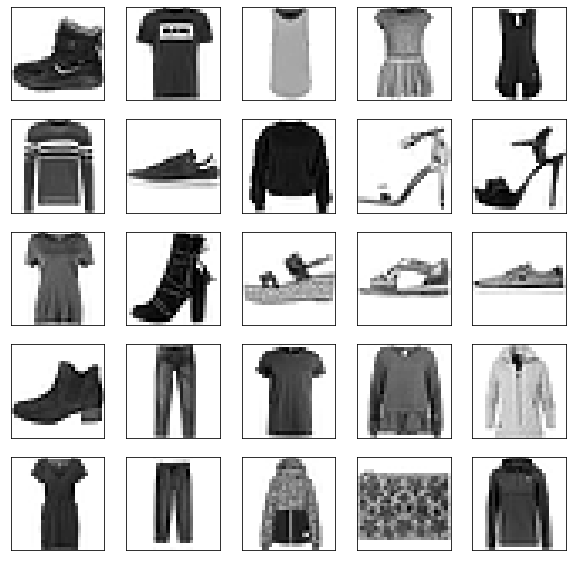

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)
plt.show()

## Task 3: Create Batches of Training Data

In [5]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

## Task 4: Build the Generator Network for DCGAN

![GAN](DCGAN.png)

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

In [6]:
num_features = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape = [num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding = 'SAME', activation = 'selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding = 'SAME', activation = 'tanh')
])


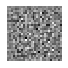

In [7]:
noise = tf.random.normal(shape=[1,num_features])
generated_image = generator(noise, training=False)
plot_utils.show(generated_image)

## Task 5: Build the Discriminator Network for DCGAN

In [8]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding = 'SAME', input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding = 'SAME'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50057536]], shape=(1, 1), dtype=float32)


## Task 6: Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [10]:
discriminator.compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop'
)
discriminator.trainable=False
gen = keras.models.Sequential([generator, discriminator])
gen.compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop'
)

## Task 7: Define Training Procedure

In [11]:
seed = tf.random.normal(shape=[batch_size, 100])

In [13]:
def train_dcgan(gan, dataset, bach_size, num_features, epochs = 5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epochs{}/{}".format(epoch + 1, epochs))
        for x_batch in dataset:
            noise = tf.random.normal(shape = (batch_size, num_features))
            generated_images = generator(noise)
            x_fake_and_real = tf.concat([generated_images, x_batch], axis = 0)
            y = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable=True
            discriminator.train_on_batch(x_fake_and_real, y)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable=False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [14]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Task 8: Train DCGAN

In [15]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. -1.

In [16]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(True)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

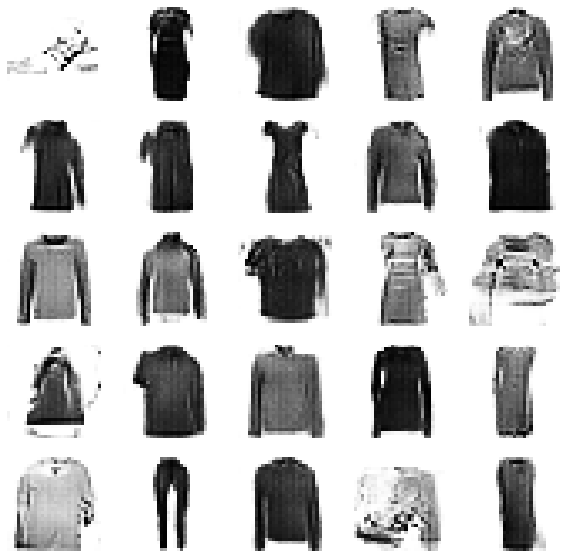

CPU times: user 5min 44s, sys: 8.37 s, total: 5min 52s
Wall time: 8min 53s


In [17]:
%%time
train_dcgan(gen, dataset, batch_size, num_features, epochs = 10)

## Task 9: Generate Synthetic Images with DCGAN

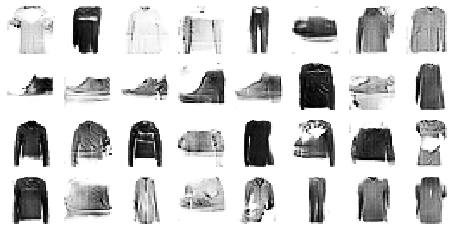

In [18]:
noise = tf.random.normal(shape = (batch_size, num_features))
generated_images = generator(noise)
plot_utils.show(generated_images, 8)


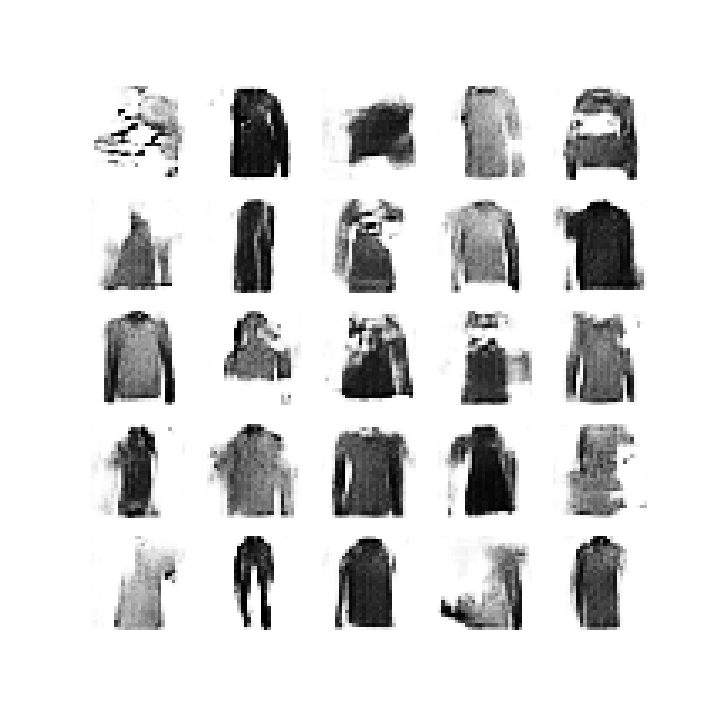

In [19]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)